In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from wordcloud import WordCloud

In [74]:
data1 = pd.read_excel('./cumcm2018c1.xlsx')
data2 = pd.read_csv('./cumcm2018c2.csv', encoding='UTF-8')

In [75]:
#重复值处理
data1['kh'] = data1['kh'].drop_duplicates()
print(data1['kh'].shape)

(194740,)


In [76]:
data1['csrq'] = pd.to_datetime(data1['csrq']) #转化为日期格式数据
data1['djsj'] = pd.to_datetime(data1['djsj'])
data2['dtime'] = pd.to_datetime(data2['dtime'])

In [77]:
data1 = data1.dropna()#缺失值处理
data2 = data2.dropna()
data1.isnull().sum()
data2.isnull().sum()

kh       0
dtime    0
spbm     0
sl       0
sj       0
je       0
spmc     0
jf       0
syjh     0
djh      0
gzbm     0
gzmc     0
dtype: int64

In [78]:
#异常值处理
data2.describe().astype(int)
data2 = data2.drop(data2[data2.sl < 0].index)
data2 = data2.drop(data2[data2.je < 0].index)
data2 = data2.drop(data2[data2.jf < 0].index)
print(data2.describe().astype(int))

           sl       sj       je      jf    syjh    gzbm
count  849697   849697   849697  849697  849697  849697
mean        1     1400     1375    1066     106    6313
std         1     3247     3238    2012      82    2373
min         1        0        0       0       1    1001
25%         1      330      324     190      41    4334
50%         1      695      690     520      97    8064
75%         1     1584     1550    1282     156    8123
max      1492  1342515  1342515  268503     320    9005


In [79]:
data = pd.merge(data1,data2, on='kh')#合并会员表与销售表

In [80]:
kh = data['spbm'].groupby(data['kh'])#会员用户信息表
kh = kh.count().reset_index()
user = kh['kh']
user = user.reset_index()
user = pd.merge(data1,user, on='kh')

In [81]:
#计算年龄
now_year = dt.date.today().year-2
user['年龄'] =now_year-user.csrq.dt.year
user = user.drop('index',axis=1)
user = user.drop('csrq',axis=1)
user.columns = ['会员卡号','性别','会员注册时间','年龄']

In [82]:
user = user.drop(user[user.年龄 > 100].index)#将年龄不符合常理的数据剔除
user = user.drop(user[user.年龄 < 15].index)
user['年龄'].describe().astype(int)

count    31145
mean        41
std         10
min         16
25%         33
50%         41
75%         48
max         97
Name: 年龄, dtype: int32

In [83]:
listBins = [15,35,60,100]#年龄层分层
listLabels = ['青年', '中年', '老年']
ap = user[['年龄']]
for i in ap:
    user['年龄层'] = pd.cut(user[i], bins=listBins, labels=listLabels, include_lowest=True)

In [84]:
user['性别'] = user['性别'].replace(1,'男')#将性别转换为中文
user['性别'] = user['性别'].replace(0,'女')

In [85]:
jf = data['jf'].groupby(data['kh'])#会员积分
jf = jf.sum().reset_index()
user = pd.merge(user,jf, left_on='会员卡号',right_on='kh',how='inner')
user = user.drop('kh',axis=1)
user.columns = ['会员卡号','性别','会员注册时间','年龄','年龄层','会员积分']

In [86]:
user = user.drop(user[user.会员积分 < 0].index)#将会员积分不符合常理的数据剔除
user['会员积分'].describe().astype(int)

count      31145
mean       14056
std        37501
min            0
25%         1300
50%         3980
75%        11774
max      1396714
Name: 会员积分, dtype: int32

In [87]:
listBins = [0,3000,5000,10000]#积分分层
listLabels = ['积分等级低', '积分等级中', '积分等级高']
ap = user[['会员积分']]
for i in ap:
    user['积分等级'] = pd.cut(user[i], bins=listBins, labels=listLabels, include_lowest=True)
user['积分等级'] = user['积分等级'].fillna('积分等级高')

In [88]:
data['total'] = data.je#每次购物的消费金额
total_cus = data['total'].groupby(data['kh'])
total_cus = total_cus.sum().reset_index()
user = pd.merge(user,total_cus, left_on='会员卡号',right_on='kh',how='inner')
user = user.drop('kh',axis=1)
user.columns = ['会员卡号','性别','会员注册时间','年龄','年龄层','会员积分','积分等级','消费金额']

In [89]:
user = user.drop(user[user.消费金额 < 0].index)#将消费金额中不符合常理的数据剔除
user['消费金额'].describe().astype(int) 

count      31145
mean       18313
std        51612
min            0
25%         1848
50%         5235
75%        15526
max      3257257
Name: 消费金额, dtype: int32

In [90]:
listBins = [0,5000,10000,15000]#消费水平分层
listLabels = ['低消费', '中消费', '高消费']
ap = user[['消费金额']]
for i in ap:
    user['消费水平'] = pd.cut(user[i], bins=listBins, labels=listLabels, include_lowest=True)
user['消费水平'] = user['消费水平'].fillna('高消费')

In [91]:
cus = data['djh'].groupby(data['kh']).count().reset_index()#消费次数
user = pd.merge(user,cus, left_on='会员卡号',right_on='kh',how='inner')
user = user.drop('kh',axis=1)
user.columns = ['会员卡号','性别','会员注册时间','年龄','年龄层','会员积分','积分等级','消费金额','消费水平','消费次数']

In [92]:
spmc = data.groupby(by=['kh'])[['spmc','gzmc']].agg({"喜好的商品类别统计":np.max})#商品偏好
user = pd.merge(user,spmc, left_on='会员卡号',right_on='kh',how='inner')
user.columns = ['会员卡号','性别','会员注册时间','年龄',
                '年龄层','会员积分','积分等级','消费金额',
                '消费水平','消费次数','喜好的商品','喜好的商品柜台']

In [93]:
date = data[['kh','dtime']]#提取月日
date['month'] = data.dtime.dt.month
date['hour'] = data.dtime.dt.hour

C:\Users\zzx\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\zzx\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [95]:
listBins = [1,3,6,9,12]#季节划分
listLabels = ['冬季','春季','夏季','秋季']
mg = date[['month']]
for i in mg:
    date['季节偏好'] = pd.cut(date[i], bins=listBins, right=False, labels=listLabels, include_lowest=True, duplicates='drop')

date['季节偏好'] = date['季节偏好'].fillna('冬季')

C:\Users\zzx\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\zzx\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [96]:
listBins = [0,6,11,13,18,24]#时间段划分
listLabels = ['凌晨', '早上', '中午', '下午', '晚上']
hg = date[['hour']]
for i in hg:
    date['时间段偏好'] = pd.cut(date[i], bins=listBins, labels=listLabels, include_lowest=True)

C:\Users\zzx\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [97]:
date = date.drop('dtime',axis=1)
date = date.drop('month',axis=1)
date = date.drop('hour',axis=1)
user = pd.merge(user,date, left_on='会员卡号',right_on='kh',how='inner')
user = user.drop('kh',axis=1)

In [98]:
portrait = user[['会员卡号','性别','年龄层','积分等级','消费水平','消费次数','喜好的商品','喜好的商品柜台','季节偏好','时间段偏好']]

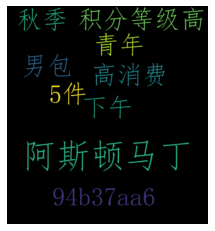

In [99]:
#随机抽取
random = portrait.sample(n=1,random_state=0)
random.to_csv('./random.txt', sep='\t',index=False, header=None)
#绘制词云
path_txt='D://python-workspace/random.txt'
f = open(path_txt,'r',encoding='UTF-8').read()
w = wordcloud = WordCloud(
    font_path="C:/Windows/Fonts/simfang.ttf",
    background_color="black",
    width=1200,height=1300).generate(f)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
w.to_file("wordcloud.png")

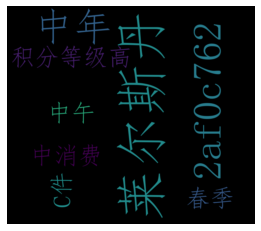

,会员卡号,性别,年龄层,积分等级,消费水平,消费次数,喜好的商品,喜好的商品柜台,月份偏好,时间段偏好
133781,2af0c762,女,中年,积分等级高,中消费,20,莱尔斯丹 C件,莱尔斯丹（新）,春季,中午
